In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

In [2]:
x = pd.read_csv("../data/X_station_train.csv")
y = pd.read_csv("../data/Y_train.csv")

In [3]:
x.rename(columns = {"number_sta"  : "station id",
          "ff" : "wind speed (m/s)",
          "t" :  "temperature (K)",
          "td" : "dew point (K)",
          "hu" : "humidity (%)",
          "dd" : "wind direction (°)",
          "precip" : "current precipitation (kg/m2)",
          "Id" : "Id_hour"},
         inplace=True)

In [4]:
x.drop(["wind direction (°)", "wind speed (m/s)"], axis=1, inplace=True)

In [5]:
x["Id"] = x["Id_hour"].apply(lambda x : "_".join(x.split("_")[:-1]))

In [6]:
x = x.merge(y[["Id", "Ground_truth"]], how="left", on="Id")

In [7]:
x.dropna(inplace=True)

In [8]:
x_normalized = pd.DataFrame(data = x.values, columns=x.columns)
for col in ["temperature (K)","dew point (K)","humidity (%)", "current precipitation (kg/m2)",] :
    x_normalized[col] = x_normalized[col] - x_normalized[col].min()
    x_normalized[col] = x_normalized[col] / x_normalized[col].max()

In [9]:
x_normalized_sample = x_normalized.sample(n=10000, random_state=42, ignore_index=False)

In [10]:
pca = PCA(n_components=2).fit(x_normalized[["temperature (K)","dew point (K)","humidity (%)", "current precipitation (kg/m2)"]])
pcs = pca.fit_transform(x_normalized_sample[["temperature (K)","dew point (K)","humidity (%)", "current precipitation (kg/m2)"]])

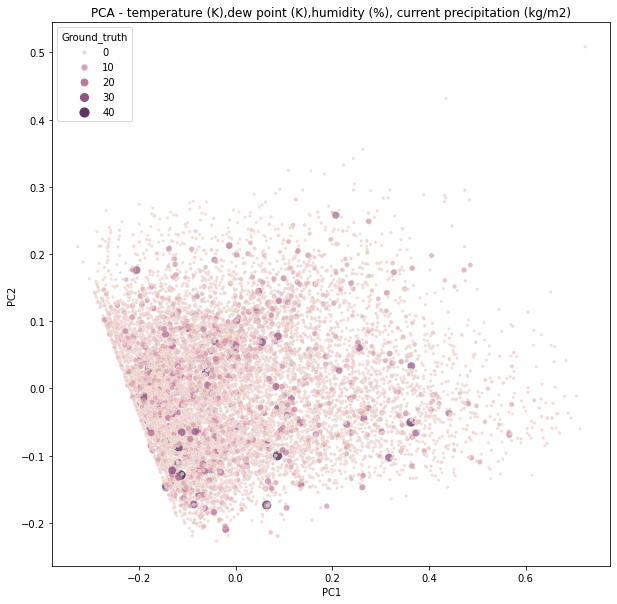

In [11]:
cmap = sns.cubehelix_palette(as_cmap=True)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title("PCA - temperature (K),dew point (K),humidity (%), current precipitation (kg/m2)")
sns.scatterplot(x=pcs[:,0], y=pcs[:,1],
                hue=x_normalized_sample["Ground_truth"],
                size=x_normalized_sample["Ground_truth"],
                palette=cmap,
                sizes=(10,100),
                ax=ax,
                alpha=.75)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [12]:
x_sample = x.sample(n=10000, random_state=42, ignore_index=False)

<Figure size 1440x14400 with 0 Axes>

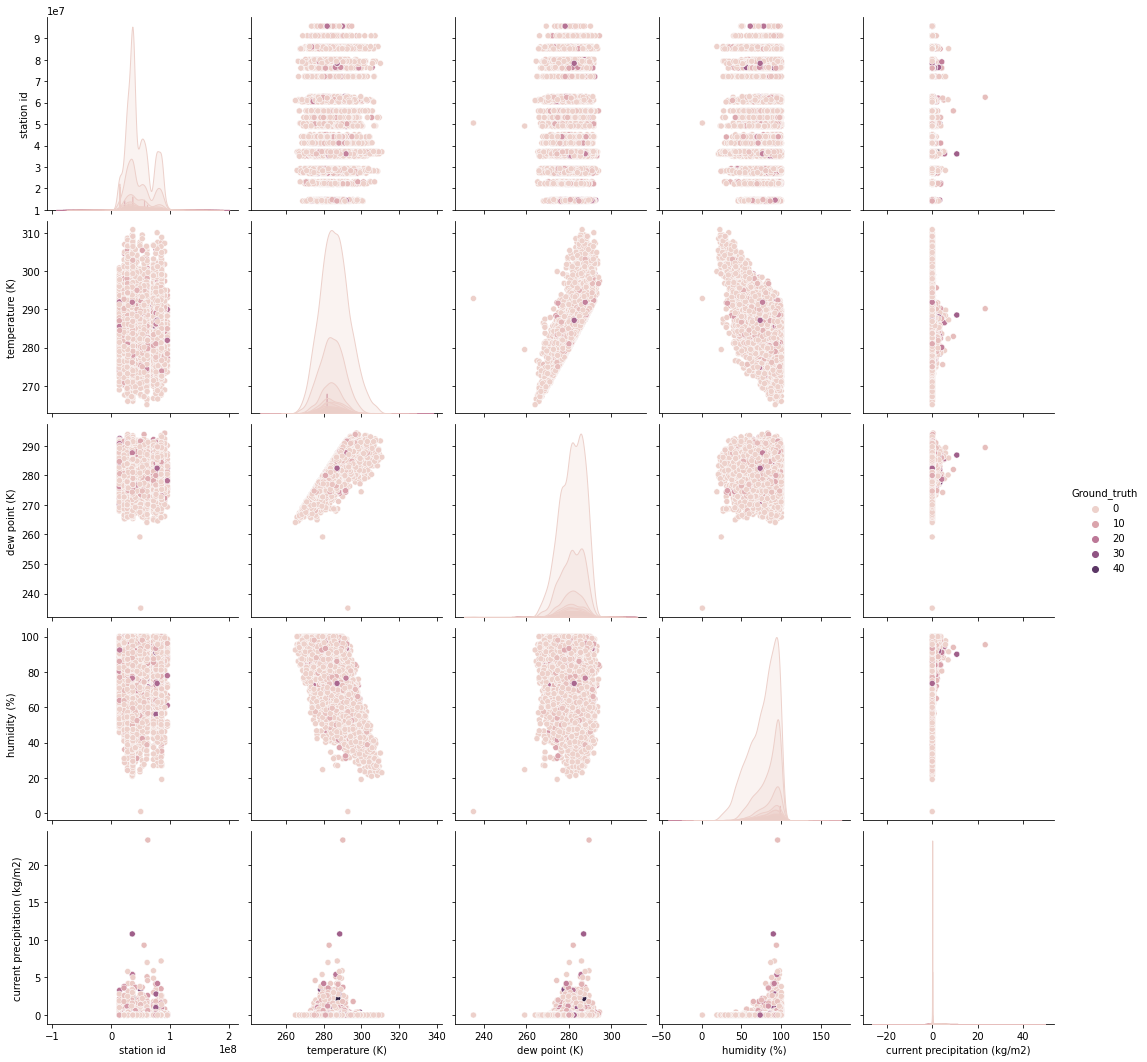

In [13]:
plt.figure(figsize=(20,200))
sns.pairplot(data=x_sample.drop(["date", "Id_hour","Id"], axis=1),
             hue="Ground_truth",
             height=3)
plt.show()

In [14]:
months = [[31,29,31,30,31,30,31,31,30,31,30,31],
           [31,28,31,30,31,30,31,31,30,31,30,31]]
x_by_date = pd.DataFrame(data=x.values, columns=x.columns)

In [15]:
x_by_date["date"] = pd.to_datetime(x_by_date["date"])

In [16]:
x_by_date["day"] = x_by_date["date"].apply(lambda x : int(x.day + np.sum(months[x.year-2016][:x.month-1]) + (x.year-2016)*366))

In [17]:
x_by_date["day"] = x_by_date["day"].astype("category")
x_by_date = x_by_date.drop(["date","Id","Id_hour"],axis=1).groupby("day").agg({
    "station id" : "first",
    "dew point (K)" : pd.Series.mean,
    "temperature (K)" : pd.Series.mean,
    "humidity (%)" : pd.Series.mean,
    "current precipitation (kg/m2)" : pd.Series.sum,
    "Ground_truth" : pd.Series.sum,
})

In [18]:
x_by_date.reset_index(inplace=True)

In [19]:
x_by_date.head()

,day,station id,dew point (K),temperature (K),humidity (%),current precipitation (kg/m2),Ground_truth
0,1,14066001,279.002981,280.497507,90.655069,218.6,15450.2
1,2,14066001,279.320006,282.112742,83.058437,629.0,53060.9
2,3,14066001,279.503762,280.948322,90.823134,2203.1,11511.8
3,4,14066001,278.284427,280.719875,85.015648,477.4,13810.3
4,5,14066001,278.548073,280.495812,87.710855,556.8,24335.8


dew point (K) by day
	OK
temperature (K) by day
	OK
humidity (%) by day
	OK
current precipitation (kg/m2) by day
	OK


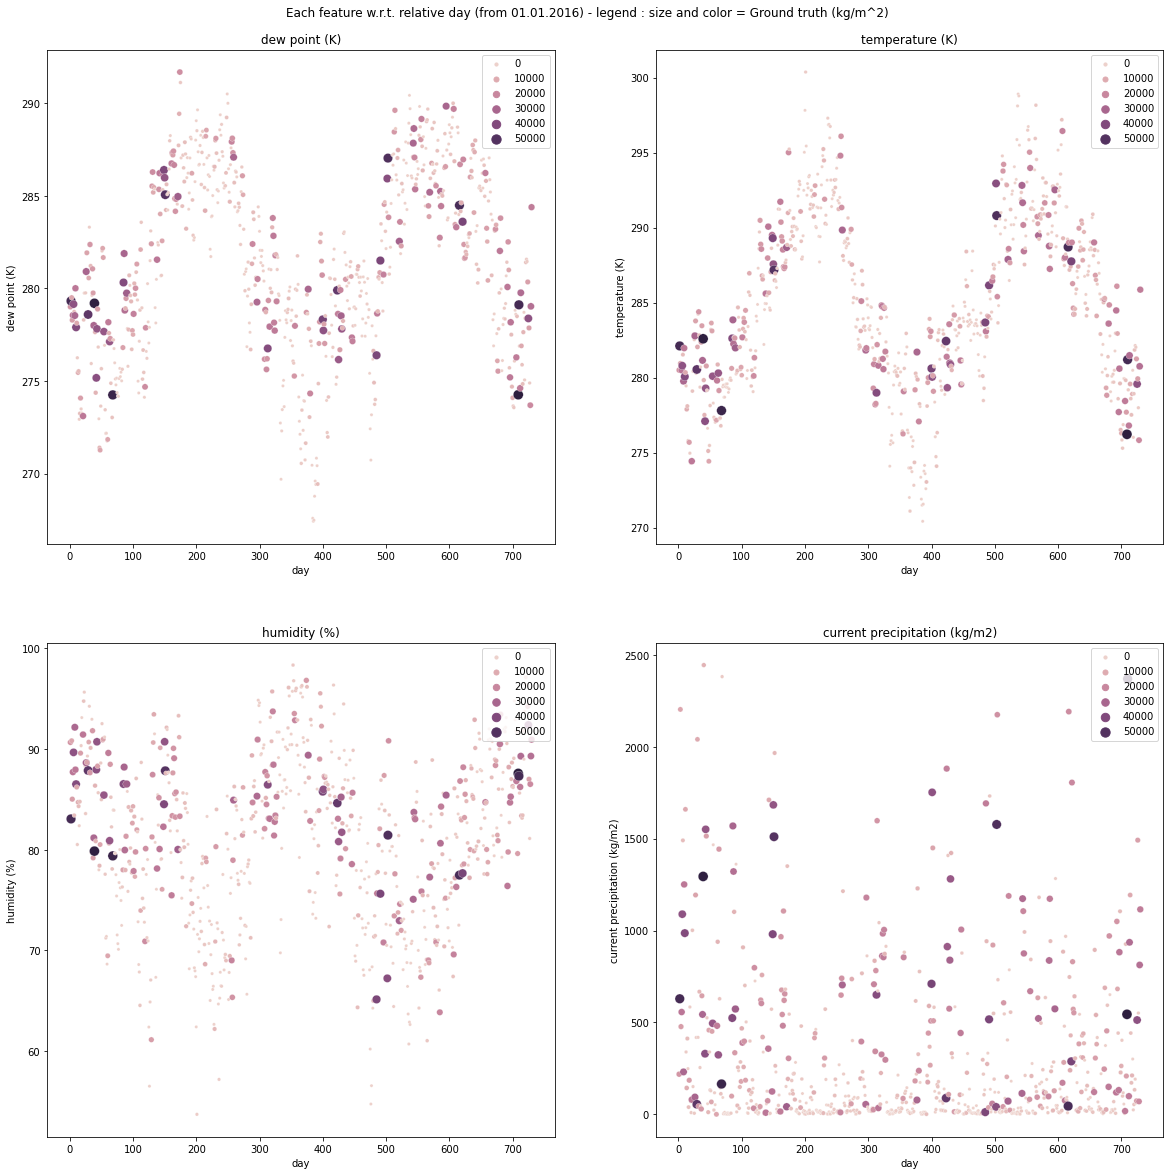

In [20]:
plt.figure(figsize=(20,20))
i=0
for col in ["dew point (K)", "temperature (K)", "humidity (%)", "current precipitation (kg/m2)"] :
    print(col+" by day")
    i+=1
    plt.subplot(2,2,i)
    plt.title(col)
    sns.scatterplot(data=x_by_date, x="day", y=col, hue="Ground_truth", size="Ground_truth", sizes=(10,100))
    plt.legend(loc="upper right")
    print("\tOK")
plt.suptitle("Each feature w.r.t. relative day (from 01.01.2016) - legend : size and color = Ground truth (kg/m^2)",y=.91)
plt.show()

hist temperature (K)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	OK
hist dew point (K)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	OK
hist humidity (%)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	OK
hist current precipitation (kg/m2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	OK


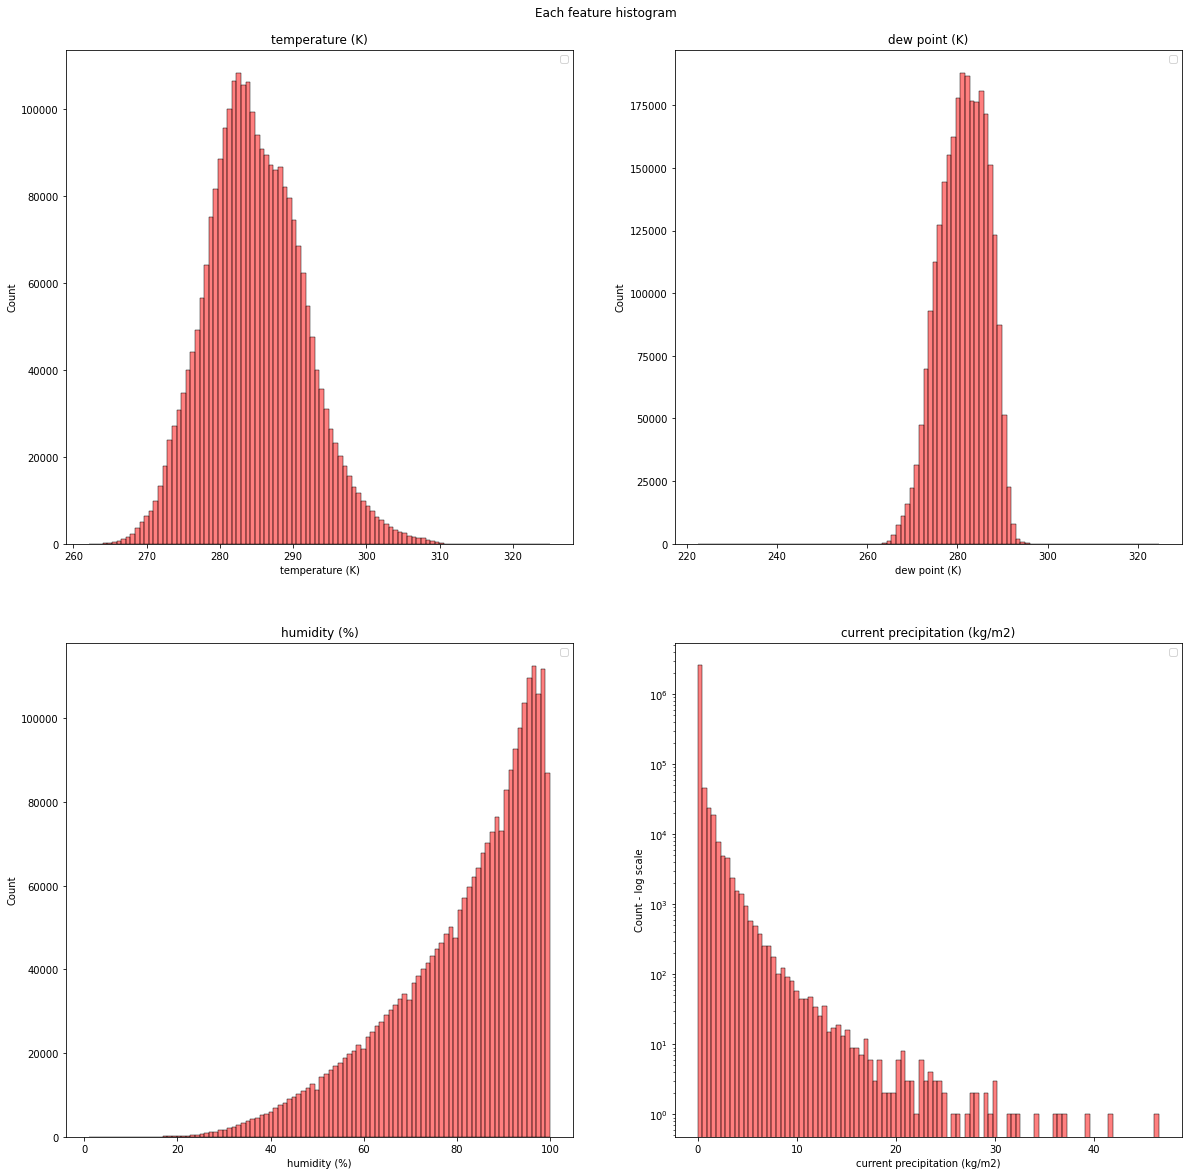

In [39]:
plt.figure(figsize=(20,20))
cmap = sns.cubehelix_palette(as_cmap=True)
i=0
for col in ['temperature (K)', 'dew point (K)', 'humidity (%)', 'current precipitation (kg/m2)'] :
    print("hist "+col)
    i+=1
    plt.subplot(2,2,i)
    plt.title(col)
    sns.histplot(data=x, x=col, bins=100, color="red", alpha=0.5 ,palette=cmap)
    plt.legend(loc="upper right")
    print("\tOK")
plt.yscale("log")
plt.ylabel("Count - log scale")
plt.suptitle("Each feature histogram",y=.91)
plt.show()